In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300 # Also set for saved figures

In [ ]:
# PPO_METRICS_PATH = '/om/user/kspiv/protein-evolution/logs/ppo_avGFP_raw_MLP_2026-01-17/ppo_metrics.pkl'
PPO_METRICS_PATH = '/om/user/kspiv/protein-evolution/logs/ppo_avGFP_ESM_MLP_2026-01-14/ppo_metrics.pkl'
# SAVE_PATH = '/om/user/kspiv/aurora/raw_MLP_lollipop.png'
SAVE_PATH = '/om/user/kspiv/aurora/ESM_MLP_lollipop.png'

DMS_PATH = '/om/user/kspiv/protein-evolution/data/Somermeyer2022_avGFP_dms_filtered.csv'
WT_PATH = '/om/user/kspiv/protein-evolution/data/avgfp_wt.txt'

FONTSIZE = 4
THRESHOLD = 0.3 # mut must be > this percent of all mutations to appear in the figure

Total unique mutations: 964
Example rows:
   position mutation  frequency  percentage label
0         1        N          1         0.1   M1N
1         1        V          1         0.1   M1V
2         2        Y          1         0.1   S2Y
3         3        C          1         0.1   K3C
4         3        M          2         0.1   K3M
5         3        T          1         0.1   K3T
6         4        A          6         0.3   G4A
7         4        C          1         0.1   G4C
8         4        D          4         0.2   G4D
9         4        E          5         0.3   G4E
Total unique mutations: 1803
Example rows:
   position mutation  frequency  percentage label
0         3        E        488         0.2   K3E
1         3        M        176         0.1   K3M
2         3        N         19         0.0   K3N
3         3        Q         21         0.0   K3Q
4         3        R        524         0.3   K3R
5         3        T         26         0.0   K3T
6         4    

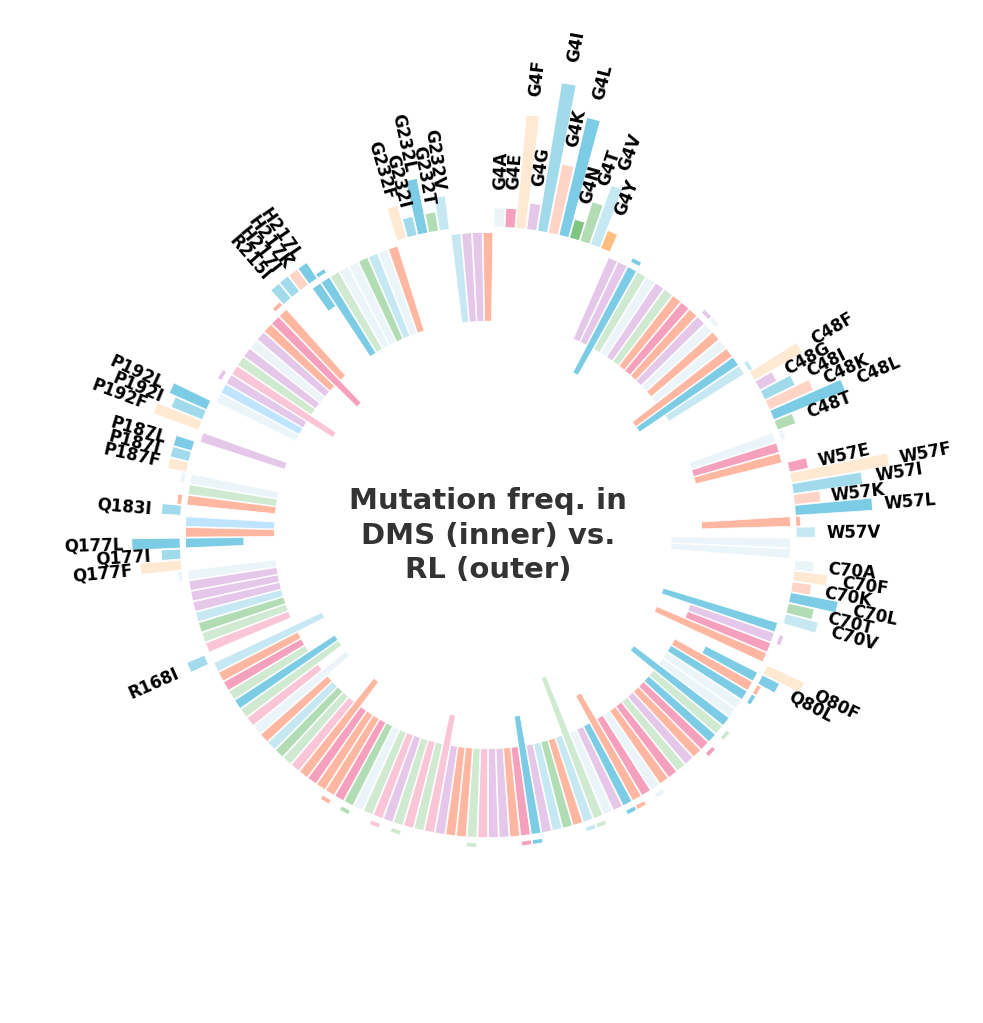


Total mutations plotted: 177
Outer ring (your mutations with >0%): 80
Inner ring (DMS with >0%): 129

Figure optimized for ICML single column (3.5" x 3.5")
Saved as both PNG (600 DPI) and PDF for publication


In [ ]:
with open(PPO_METRICS_PATH, 'rb') as f:
    metrics = pickle.load(f)
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
idx_to_aa = {i: aa for aa, i in aa_to_idx.items()}

mutations = [(a[0], idx_to_aa[a[1]]) for a in metrics['actions']]
with open(WT_PATH, 'r') as file:
    wt = file.readline().strip()
df_dms = pd.read_csv(DMS_PATH)

# ============================================================================
# STEP 1: Process mutation data - ONE ROW PER POSITION-MUTATION PAIR
# ============================================================================

# Count each specific mutation (position, amino acid)
mutation_counts = Counter(mutations)  # e.g. 119 went to E 20 times

# Create dataframe with one row per unique mutation
mutation_df = pd.DataFrame([
    {
        'position': pos+1,  # was 0 indexed at first
        'mutation': aa,
        'frequency': count
    }
    for (pos, aa), count in mutation_counts.items()
])

# Sort by position then mutation
mutation_df = mutation_df.sort_values(['position', 'mutation']).reset_index(drop=True)

# Calculate percentage
total_mutations = len(mutations)
mutation_df['percentage'] = (mutation_df['frequency'] / total_mutations * 100).round(1)

# Create label
mutation_df['label'] = mutation_df['position'].astype(str) + mutation_df['mutation']

for i in range(len(mutation_df)):
    mutation_df.loc[i, 'label'] = wt[mutation_df.loc[i, 'position'] - 1] + mutation_df.loc[i, 'label']

print(f"Total unique mutations: {len(mutation_df)}")
print(f"Example rows:")
print(mutation_df.head(10))

# ============================================================================
# STEP 2: Process DMS dataset for inner ring
# ============================================================================
# Extract all mutations from DMS dataset
dms_mutations = []
for seq in df_dms['mutated_sequence']:
    # Assuming you can parse mutations from the sequence
    # You'll need to compare against wildtype or extract mutations somehow
    # For now, let's assume you have a way to get (position, aa) from each sequence
    mutations = []
    for j in range(238):
        if wt[j] != seq[j]:
            dms_mutations.append((j, seq[j]))


# OR if you have mutation annotations in DMS data:
# dms_mutations = [(row['position'], row['amino_acid']) for _, row in df_dms.iterrows()]

# Count DMS mutations
dms_mutation_counts = Counter(dms_mutations)

# Create DMS dataframe
dms_df = pd.DataFrame([
    {
        'position': pos + 1,
        'mutation': aa,
        'frequency': count
    }
    for (pos, aa), count in dms_mutation_counts.items()
])
dms_df = dms_df.sort_values(['position', 'mutation']).reset_index(drop=True)
dms_df['percentage'] = (dms_df['frequency'] / len(dms_mutations) * 100).round(1)

# Create label
dms_df['label'] = dms_df['position'].astype(str) + dms_df['mutation']

for i in range(len(dms_df)):
    dms_df.loc[i, 'label'] = wt[dms_df.loc[i, 'position'] - 1] + dms_df.loc[i, 'label']

print(f"Total unique mutations: {len(dms_df)}")
print(f"Example rows:")
print(dms_df.head(10))

# ============================================================================
# STEP 3: FILTER - Keep mutations that are >= 1% in AT LEAST ONE dataset
# ============================================================================
# Create a set of mutations to keep (common in at least one dataset)
mutations_to_keep = set()

# Add mutations that are >= THRESHOLD% in your mutation set
common_in_yours = set(
    mutation_df[mutation_df['percentage'] >= THRESHOLD_RL]
    .apply(lambda row: (row['position'], row['mutation']), axis=1)
)
mutations_to_keep.update(common_in_yours)

# Add mutations that are >= 1% in DMS
common_in_dms = set(
    dms_df[dms_df['percentage'] >= THRESHOLD_DMS]
    .apply(lambda row: (row['position'], row['mutation']), axis=1)
)
mutations_to_keep.update(common_in_dms)

print(f"Mutations ≥1% in your set: {len(common_in_yours)}")
print(f"Mutations ≥1% in DMS: {len(common_in_dms)}")
print(f"Total mutations to keep (union): {len(mutations_to_keep)}")

# Filter both dataframes to only include these mutations
mutation_df_filtered = mutation_df[
    mutation_df.apply(lambda row: (row['position'], row['mutation']) in mutations_to_keep, axis=1)
].reset_index(drop=True)

dms_df_filtered = dms_df[
    dms_df.apply(lambda row: (row['position'], row['mutation']) in mutations_to_keep, axis=1)
].reset_index(drop=True)

print(f"\nYour mutations: {len(mutation_df)} -> {len(mutation_df_filtered)}")
print(f"DMS mutations: {len(dms_df)} -> {len(dms_df_filtered)}")

# Important: Fill in missing mutations with 0 frequency for alignment
# This ensures both rings have the same mutations for comparison

all_mutations_sorted = sorted(mutations_to_keep)

def fill_missing_mutations(df, all_mutations):
    """Ensure dataframe has all mutations, filling with 0 if missing"""
    existing = set(df.apply(lambda row: (row['position'], row['mutation']), axis=1))
    
    rows = []
    for pos, mut in all_mutations:
        if (pos, mut) in existing:
            # Convert Series to dict to maintain consistency
            row_data = df[(df['position'] == pos) & (df['mutation'] == mut)].iloc[0].to_dict()
            rows.append(row_data)
        else:
            rows.append({
                'position': pos,
                'mutation': mut,
                'frequency': 0,
                'percentage': 0.0,
                'label': f"{wt[pos-1]}{pos}{mut}"
            })
    
    return pd.DataFrame(rows).reset_index(drop=True)

mutation_df_filtered = fill_missing_mutations(mutation_df_filtered, all_mutations_sorted)
dms_df_filtered = fill_missing_mutations(dms_df_filtered, all_mutations_sorted)

print(f"\nAfter alignment:")
print(f"Your mutations: {len(mutation_df_filtered)} rows")
print(f"DMS mutations: {len(dms_df_filtered)} rows")
print(f"(Both should be {len(all_mutations_sorted)} - the union of common mutations)")

# ============================================================================
# STEP 4: Assign colors by amino acid
# ============================================================================

# Nice color palette for amino acids
AA_COLORS = {
    'A': '#E8F4F8', 'V': '#BCE4F0', 'I': '#90D4E8', 'L': '#64C4E0', 'M': '#64C4E0',
    'F': '#FFE6CC', 'W': '#FFCC99', 'Y': '#FFB366', 'P': '#B3E0FF',
    'S': '#C8E6C9', 'T': '#A5D6A7', 'C': '#81C784', 'N': '#66BB6A', 'Q': '#4CAF50',
    'K': '#FFCCBC', 'R': '#FFAB91', 'H': '#FF8A65',
    'D': '#F8BBD0', 'E': '#F48FB1',
    'G': '#E1BEE7'
}

mutation_df_filtered['color'] = mutation_df_filtered['mutation'].map(AA_COLORS).fillna('#CCCCCC')
dms_df_filtered['color'] = dms_df_filtered['mutation'].map(AA_COLORS).fillna('#CCCCCC')

# ============================================================================
# STEP 5: Create positions around the circle
# ============================================================================

# Both rings should have same number of elements (aligned from Step 3)
n_mutations = len(mutation_df_filtered)
angles = np.linspace(0, 2 * np.pi, n_mutations, endpoint=False)
bar_width = 2 * np.pi / n_mutations * 0.9

# ============================================================================
# STEP 6: Create the dual-ring plot - OPTIMIZED FOR SINGLE COLUMN ICML
# ============================================================================

# ICML single column width is ~3.25 inches, but we need square aspect
# Use 3.5 x 3.5 inches for single column
fig, ax = plt.subplots(figsize=(3.5, 3.5), subplot_kw={"projection": "polar"})

fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Angular axis starts at top
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Define the main circle radius (smaller overall scale)
MAIN_CIRCLE_RADIUS = 4.0

# Normalize heights - MUCH SHORTER BARS
max_outer = mutation_df_filtered['percentage'].max()
max_inner = dms_df_filtered['percentage'].max()

# Handle edge case where max is 0
if max_outer == 0:
    max_outer = 1
if max_inner == 0:
    max_inner = 1

# SHORTER BARS - reduced from 3.0 and 4.0 to 1.2 and 1.5
inner_heights = dms_df_filtered['percentage'].values / max_inner * 2
inner_colors = dms_df_filtered['color'].values

ax.bar(angles, inner_heights, 
       width=bar_width, 
       bottom=MAIN_CIRCLE_RADIUS - inner_heights,
       color=inner_colors, 
       edgecolor='white', 
       linewidth=0.2,  # Thinner edges for smaller figure
       alpha=0.85)

# OUTER RING - Your mutations (pointing outward from main circle)
outer_heights = mutation_df_filtered['percentage'].values / max_outer * 2 # HERE WAS 3
outer_colors = mutation_df_filtered['color'].values

ax.bar(angles, outer_heights, 
       width=bar_width, 
       bottom=MAIN_CIRCLE_RADIUS,
       color=outer_colors, 
       edgecolor='white', 
       linewidth=0.2,  # Thinner edges for smaller figure
       alpha=0.85)

# Add main circle line
sep_angles = np.linspace(0, 2 * np.pi, 200)
ax.plot(sep_angles, [MAIN_CIRCLE_RADIUS] * 200, color='white', linewidth=1.5, zorder=100)

# ============================================================================
# STEP 7: Add labels - LARGER TEXT, OPTIMIZED SPACING
# ============================================================================

# Label outer ring mutations - LARGER TEXT
for idx, row in mutation_df_filtered.iterrows():
    angle = angles[idx]
    height = outer_heights[idx] + MAIN_CIRCLE_RADIUS
    label = row['label']
    pct = row['percentage']
    
    # Only label if there's actually a mutation here (percentage > 0)
    if pct >= THRESHOLD:
        label_radius = height + 0.5  # Reduced spacing since bars are shorter
        
        # Adjust text rotation based on position
        rotation = np.degrees(-angle) - 90
        # ha = 'left'
        # Flip text on left side of circle so it's always readable
        if 0 < np.degrees(angle) < 180:
            rotation += 180
            # ha = 'right'
        
        # LARGER FONTSIZE: 7pt (was 12pt, but at smaller figure size this is proportionally larger)
        ax.text(angle, label_radius, f"{label}",# ({pct:.1f}%)",
                rotation=rotation, 
                ha='center', va='center', 
                fontsize=FONTSIZE, fontweight='bold')

# ============================================================================
# STEP 8: Add center label - LARGER TEXT
# ============================================================================

# Add center label - LARGER, more concise text
ax.text(0, 0, 'Mutation freq. in\nDMS (inner) vs.\nRL (outer)', 
        ha='center', va='center', 
        fontsize=7, fontweight='bold', color='#333333',
        linespacing=1.3)

# Clean up - adjusted limits for shorter bars
ax.set_ylim(0, 6)  # Reduced from 11 to accommodate shorter bars
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])
ax.grid(False)
ax.spines['polar'].set_visible(False)

plt.tight_layout()
# Save with high DPI for publication quality
plt.savefig(SAVE_PATH, 
            dpi=600, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nTotal mutations plotted: {n_mutations}")
print(f"Outer ring (your mutations with >0%): {(mutation_df_filtered['percentage'] > 0).sum()}")
print(f"Inner ring (DMS with >0%): {(dms_df_filtered['percentage'] > 0).sum()}")
print(f"\nFigure optimized for ICML single column (3.5\" x 3.5\")")
print(f"Saved as both PNG (600 DPI) and PDF for publication")